In [1]:
import os
import pickle
import pandas as pd
import tensorflow as tf
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU available: []


In [2]:
CONFIG = {
    'data_path': '../jigsaw-toxic-comment-classification-challenge/train.csv/train.csv',
    'model_base_dir': 'model',
    'max_features': 200000, 
    'sequence_length': 1800, 
    'embedding_dim': 32,
    'lstm_units': 32,
    'batch_size': 16,
    'epochs': 3,
    'validation_split': 0.2,
    'test_split': 0.1,
    'random_seed': 42
}


# Set random seeds for reproducibility
tf.random.set_seed(CONFIG['random_seed'])
np.random.seed(CONFIG['random_seed'])

In [3]:
# Load data
print(f"Loading data from: {CONFIG['data_path']}")
df = pd.read_csv(CONFIG['data_path'])

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head()

Loading data from: ../jigsaw-toxic-comment-classification-challenge/train.csv/train.csv
Dataset shape: (159571, 8)
Columns: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


toxic: 15,294 (9.58%)
severe_toxic: 1,595 (1.00%)
obscene: 8,449 (5.29%)
threat: 478 (0.30%)
insult: 7,877 (4.94%)
identity_hate: 1,405 (0.88%)


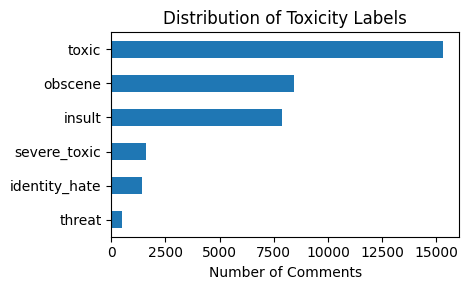

In [4]:
toxicity_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for col in toxicity_columns:
    toxic_count = df[col].sum()
    toxic_pct = (toxic_count / len(df)) * 100
    print(f"{col}: {toxic_count:,} ({toxic_pct:.2f}%)")

# Plot
fig, ax = plt.subplots(figsize=(5, 3))
toxicity_counts = df[toxicity_columns].sum().sort_values(ascending=True)
toxicity_counts.plot(kind='barh', ax=ax)
ax.set_title('Distribution of Toxicity Labels')
ax.set_xlabel('Number of Comments')
plt.tight_layout()
plt.show()

In [5]:
from tensorflow.keras.layers import TextVectorization

# Prepare data
X = df['comment_text'].values
y = df[toxicity_columns].values

print(f"Input shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Number of toxicity categories: {len(toxicity_columns)}")

Input shape: (159571,)
Target shape: (159571, 6)
Number of toxicity categories: 6


In [6]:
# Create and configure text vectorizer
vectorizer = TextVectorization(
    max_tokens=CONFIG['max_features'],
    output_sequence_length=CONFIG['sequence_length'],
    output_mode='int'
)

print("Adapting vectorizer to the text data")
vectorizer.adapt(X)

print(f"Vocabulary size: {len(vectorizer.get_vocabulary())}")
print(f"Sequence length: {CONFIG['sequence_length']}")

Adapting vectorizer to the text data
Vocabulary size: 200000
Sequence length: 1800


In [7]:
# Vectorize the text
print("Vectorizing text data")
vectorized_text = vectorizer(X)
print(f"Vectorized text shape: {vectorized_text.shape}")

Vectorizing text data
Vectorized text shape: (159571, 1800)


In [8]:
# Create TensorFlow dataset
print("Creating TensorFlow dataset")
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000, seed=CONFIG['random_seed'])
dataset = dataset.batch(CONFIG['batch_size'])
dataset = dataset.prefetch(tf.data.AUTOTUNE)

dataset_size = len(dataset)
print(f"Total dataset size: {dataset_size} batches")

Creating TensorFlow dataset
Total dataset size: 9974 batches


In [9]:
# Split dataset
train_size = int(dataset_size * (1 - CONFIG['validation_split'] - CONFIG['test_split']))
val_size = int(dataset_size * CONFIG['validation_split'])
test_size = dataset_size - train_size - val_size

train_dataset = dataset.take(train_size)
remaining_dataset = dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size)
test_dataset = remaining_dataset.skip(val_size)

print(f"Training batches: {train_size}")
print(f"Validation batches: {val_size}")
print(f"Test batches: {test_size}")

Training batches: 6981
Validation batches: 1994
Test batches: 999


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def create_model(vocab_size, embedding_dim, lstm_units, num_classes, sequence_length):
    model = Sequential([
        # Embedding layer
        Embedding(vocab_size + 1, embedding_dim, input_length=sequence_length),
        
        # Bidirectional LSTM
        Bidirectional(LSTM(lstm_units, activation='tanh')),
        
        # Dense layers for feature extraction
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        
        # Output layer (sigmoid for multi-label classification)
        Dense(num_classes, activation='sigmoid')
    ])
    
    return model

# Create the model
model = create_model(
    vocab_size=CONFIG['max_features'],
    embedding_dim=CONFIG['embedding_dim'],
    lstm_units=CONFIG['lstm_units'],
    num_classes=len(toxicity_columns),
    sequence_length=CONFIG['sequence_length']
)

model.summary()

/Users/hlecates/Desktop/Projects/guardian-comments/.venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 'precision', 'recall']
)

print("Model compiled")

Model compiled


In [12]:
# Setup callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    )
]

print("Callbacks configured")

Callbacks configured


In [13]:
# Train the model
print(f"Starting training for {CONFIG['epochs']} epochs")
history = model.fit(
    train_dataset,
    epochs=CONFIG['epochs'],
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)

print("Training complete")

Starting training for 3 epochs
Epoch 1/3
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 3378s 484ms/step - accuracy: 0.9537 - loss: 0.0668 - precision: 0.7860 - recall: 0.5454 - val_accuracy: 0.9944 - val_loss: 0.0574 - val_precision: 0.9236 - val_recall: 0.4619 - learning_rate: 0.0010
Epoch 2/3
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 3507s 502ms/step - accuracy: 0.9936 - loss: 0.0483 - precision: 0.8152 - recall: 0.6657 - val_accuracy: 0.9940 - val_loss: 0.0417 - val_precision: 0.8421 - val_recall: 0.7065 - learning_rate: 0.0010
Epoch 3/3
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 3392s 486ms/step - accuracy: 0.9903 - loss: 0.0435 - precision: 0.8199 - recall: 0.7112 - val_accuracy: 0.9938 - val_loss: 0.0382 - val_precision: 0.8478 - val_recall: 0.7176 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 3.
Training complete


In [14]:
# Evaluate on test set
print("Evaluating model on test set")
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_dataset, verbose=1)

print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {2 * (test_precision * test_recall) / (test_precision + test_recall):.4f}")


Evaluating model on test set
999/999 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.9935 - loss: 0.0395 - precision: 0.8555 - recall: 0.7224
Loss: 0.0395
Accuracy: 0.9935
Precision: 0.8555
Recall: 0.7224
F1-Score: 0.7833


In [15]:
# Create subdirectory for this epoch run (e.g., 'models/01_epochs/')
epoch_dir = os.path.join(CONFIG['model_base_dir'], f"{CONFIG['epochs']:02d}_epochs")

# Define paths
model_save_path = os.path.join(epoch_dir, 'toxicity.keras')
vectorizer_save_path = os.path.join(epoch_dir, 'vectorizer.pkl')

# Ensure directory exists
def ensure_dir_exists(file_path):
    directory = os.path.dirname(file_path)
    if directory and not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")
    return file_path

# Save model
model_path = ensure_dir_exists(model_save_path)
print(f"Saving model to: {model_path}")
model.save(model_path)

# Save vectorizer
vectorizer_path = ensure_dir_exists(vectorizer_save_path)
print(f"Saving vectorizer to: {vectorizer_path}")
with open(vectorizer_path, 'wb') as f:
    pickle.dump(vectorizer, f)

# Output file sizes
print("\nModel and vectorizer saved")
print(f"Model file size: {os.path.getsize(model_path) / (1024*1024):.1f} MB")
print(f"Vectorizer file size: {os.path.getsize(vectorizer_path) / (1024*1024):.1f} MB")

Created directory: model/03_epochs
Saving model to: model/03_epochs/toxicity.keras
Saving vectorizer to: model/03_epochs/vectorizer.pkl

Model and vectorizer saved
Model file size: 74.3 MB
Vectorizer file size: 4.5 MB


In [16]:
# Test loading and prediction
print("Testing model")

# Load the saved model and vectorizer
loaded_model = tf.keras.models.load_model(model_path)
with open(vectorizer_path, 'rb') as f:
    loaded_vectorizer = pickle.load(f)

# Test with sample comments
test_comments = [
    "You are such an idiot!",
    "This is a great article, thanks for sharing.",
    "I hope you die in a fire!",
    "Could you please explain this better?"
]

print("\nTest predictions:")
for comment in test_comments:
    # Vectorize comment
    vectorized_comment = loaded_vectorizer([comment])
    
    # Make prediction
    prediction = loaded_model.predict(vectorized_comment, verbose=0)
    
    # Format results
    print(f"\nComment: '{comment}'")
    for i, category in enumerate(toxicity_columns):
        prob = prediction[0][i]
        is_toxic = prob > 0.5
        print(f"  {category}: {prob:.3f} {'(TOXIC)' if is_toxic else '(clean)'}")

print("\nModel loading and prediction successful")


Testing model

Test predictions:

Comment: 'You are such an idiot!'
  toxic: 0.948 (TOXIC)
  severe_toxic: 0.065 (clean)
  obscene: 0.696 (TOXIC)
  threat: 0.033 (clean)
  insult: 0.581 (TOXIC)
  identity_hate: 0.098 (clean)

Comment: 'This is a great article, thanks for sharing.'
  toxic: 0.003 (clean)
  severe_toxic: 0.000 (clean)
  obscene: 0.000 (clean)
  threat: 0.000 (clean)
  insult: 0.000 (clean)
  identity_hate: 0.000 (clean)

Comment: 'I hope you die in a fire!'
  toxic: 0.838 (TOXIC)
  severe_toxic: 0.006 (clean)
  obscene: 0.322 (clean)
  threat: 0.013 (clean)
  insult: 0.346 (clean)
  identity_hate: 0.039 (clean)

Comment: 'Could you please explain this better?'
  toxic: 0.000 (clean)
  severe_toxic: 0.000 (clean)
  obscene: 0.000 (clean)
  threat: 0.000 (clean)
  insult: 0.000 (clean)
  identity_hate: 0.000 (clean)

Model loading and prediction successful
